# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Initializing

In [3]:
def initialise_boundary(top, left, right, bottom, T_ambient, corners=[0,0,0,0], Get_T_K=True):
    '''
    Takes in the boundary values and fills all the middle points in with either 0 for T_0 
    or the ambient (starting) temperature to T_k
    adds the corners in either averaged with the points around them or defined prior
    '''
    cols = len(top)+2
    rows = len(left)+2
    
    middle_zeros = np.array([0 for i in top])
    
    if corners == [0,0,0,0]:
        initial_top = np.append(np.append([(top[0]+left[0])/2],top), [(top[-1]+right[0])/2])
        initial_bottom = np.append(np.append([(bottom[0]+left[-1])/2],bottom), [(bottom[-1]+right[-1])/2])
    else:
        initial_top = np.append(np.append([corners[0]],top), [corners[1]])
        initial_bottom = np.append(np.append([corners[2]],bottom), [corners[3]])
    
    
    
    middle = np.array(np.append([np.append(np.append([left[i]], middle_zeros), [right[i]]) for i in range(rows-2)],[]))
    
    initial_array = np.append(np.append(initial_top, middle), initial_bottom)
    initial_matrix_T_0 = np.matrix(initial_array.reshape(rows, cols))
    
    if not Get_T_K:
        return initial_matrix_T_0
    
    else:
        middle_ambient = np.array([T_ambient for i in top])
        middle_ambient = np.array(np.append([np.append(np.append([left[i]], middle_ambient), [right[i]]) for i in range(rows-2)],[]))
        initial_array = np.append(np.append(initial_top, middle_ambient), initial_bottom)
        initial_matrix_T_k = np.matrix(initial_array.reshape(rows, cols))
        return initial_matrix_T_0, initial_matrix_T_k

# Updates

In [4]:
def update_with_source(T_k, T_0, q, h):
    # This new update function will use the fact that there will be a source term at each of the points
    # it will also update the new T_0 with the BC
    
    T_kP1 = T_0.copy()
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            # the k_si and T_a which are global variables come from dimensionless and h = 1/stepsize(m)
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j]) + 1/4 * q *h **2 / (K_si*T_a)
            
    T_0_new = update_processor_boundary(T_kP1, T_0, h)
    
    return T_kP1, T_0_new

In [5]:
def update_processor_boundary(T_k, T_0, h):
    # Take in T_k wich has a border of imaginary values
    # We want to update every value on the T_0 boundary
    # This is done by taking the value of T_k at the boundary (1 before the imagniary points)
    # Then calculating the gradient due to natural convection
    # Then creating new imaginary points which are then used to update the T_0
    
    # we will do the top first
    top = T_k[1].A1[1:-1] # get rid of the end terms with the [1:-1] term
    second_top = T_k[2].A1[1:-1]
    grad_top = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in top]) 
    new_top = new_imaginary_points(grad_top, second_top, h)
    
    col_list = T_k.transpose()
    left = col_list[1].A1[1:-1]
    second_left = col_list[2].A1[1:-1]
    grad_left = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in left])
    new_left = new_imaginary_points(grad_left, second_left, h)
    
    bottom = T_k[-2].A1[1:-1]
    second_bottom = T_k[-3].A1[1:-1]
    grad_bottom = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in bottom])
    new_bottom = new_imaginary_points(grad_bottom, second_bottom, h)
    
    right = col_list[-2].A1[1:-1]
    second_right = col_list[-3].A1[1:-1]
    grad_right = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in right])
    new_right = new_imaginary_points(grad_right, second_right,  h)
    
    T_0_new = initialise_boundary(new_top, new_left, new_right, new_bottom, T_a, [0,0,0,0], Get_T_K=False)
    return T_0_new

# Calculators

In [6]:
def gradient_nat_convection(T_k_i, T_ambient, k_silicon, h):
    value = - h_nat(T_k_i, T_ambient)/ k_silicon * (T_k_i - 293/T_ambient)
    return value

def h_nat(T_s_hat, T_a):
    return 1.31*(T_s_hat*T_a - 293)**(1/3)

def new_imaginary_points(grad, previous_points, h):
    return previous_points + 2*h*grad

# Plot

In [7]:
def plot(T):
    fig, ax = plt.subplots()
    im = ax.imshow(T, cmap='plasma')
    plt.show()
    #fig.suptitle('Temperature map')
    #cbar = ax.figure.colorbar(im, orientation='horizontal')
    #cbar.ax.set_xlabel('Temperature Scale')
    #plt.show()

# Initial constant values

In [8]:
q = 0.5*1e9 # W/m^3
T_a = 293 # K
K_si = 150 # W/mK
h = 1e-4 # m

# Test to find working temperature
Expected $T_{average} \approx$ 30 * $T_{ambient}$ 

Therefore in our tests, we will start from above and show it wants to decrease

and start from below and show it wants to increase

### Above

In [30]:
ambient = 40

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [31]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

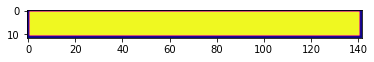

39.9997768264814 -0.00022317351859868495


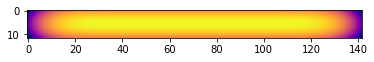

39.99540806237209 -1.6651163598169205e-05


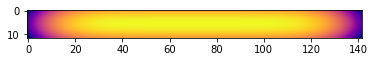

39.9912572299845 -1.656884616352272e-05


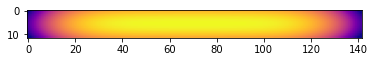

39.98712046425514 -1.652884542835409e-05


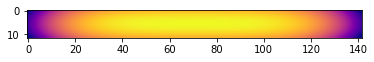

39.98299174355411 -1.6502471098078786e-05


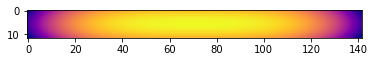

39.97886872867177 -1.6482494714864515e-05


KeyboardInterrupt: 

In [32]:
avT_k_1 = ambient
diff_array = []
av_array = []


for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
    diff = avT_k-avT_k_1
    avT_k_1 = avT_k
    
    if i%250 == 0:
        plot(T_k_updated)        
        print(avT_k, diff)

    if i%100 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

Each iteration is clearly decreasing

### Below

In [33]:
ambient = 20

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [34]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

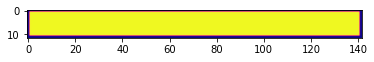

19.999945624714943 -5.437528505680689e-05


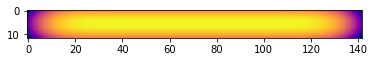

20.00252618522823 1.0643446820779445e-05


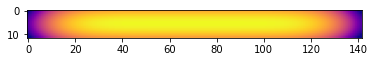

20.00519105410658 1.0670263296930216e-05


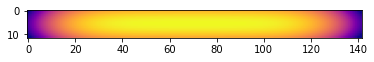

20.007860059752115 1.0680399270768248e-05


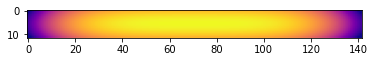

20.010530829089262 1.0685167151081032e-05


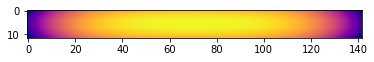

20.013202440883678 1.06874164309545e-05


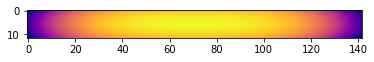

20.01587442210414 1.0688247797929762e-05


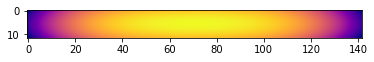

20.018546491464864 1.0688187483509637e-05


KeyboardInterrupt: 

In [35]:
avT_k_1 = ambient
diff_array = []
av_array = []


for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
    diff = avT_k-avT_k_1
    avT_k_1 = avT_k
    
    if i%250 == 0:
        plot(T_k_updated)        
        print(avT_k, diff)

    if i%100 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

apart from the first run where it is changing to get the correct shape, there is clearly an increase in each run meaning there is a turning point within the range of 20-40 as we predicted

# sped up version by normalising to a much higher temperature

by normalising to a higher temperature we can have the solution on the order of magnitude of 1 which should speed up the convergence to the correct value

In [9]:
q = 0.5*1e9 # W/m^3
T_a = 293*28 # K
K_si = 150 # W/mK
h = 1e-4 # m

In [37]:
ambient = 1

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [38]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

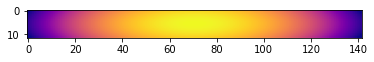

1.0166644701046428 0.0005004200928999669


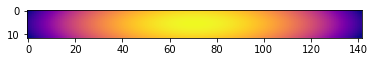

1.016664734563323 2.6445868028801556e-07


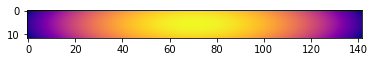

1.0166650027419468 2.681786237523909e-07


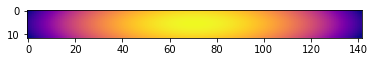

1.0166652707602042 2.680182573655543e-07


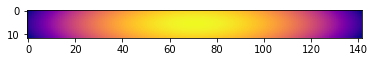

1.0166655385012755 2.677410713136652e-07


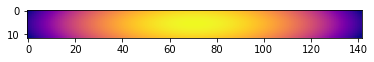

1.0166658059283777 2.6742710224070265e-07


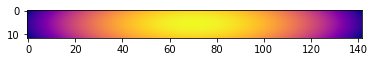

1.016666073023732 2.6709535427826836e-07


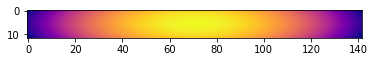

1.0166663397773015 2.6675356945560225e-07


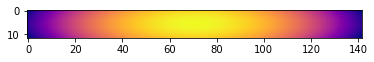

1.0166666061832554 2.664059539636554e-07


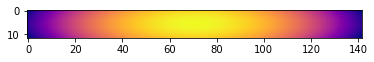

1.0166668722382282 2.660549727195871e-07


In [50]:
#avT_k_1 = ambient
diff_array = []
av_array = []

T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated+0.0005, q, h)

for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    if i%1000 == 0:
        plot(trim(T_k_updated))        
        avT_k = sum(trim(T_k_updated).ravel().A1)/(len(trim(T_k_updated))*len(trim(T_k_updated)[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

# Test with it being further away

In [51]:
ambient = 1.5

top = np.array([ambient for i in range(140)])
bottom = top.copy()
left = np.array([ambient for i in range(10)])
right = left.copy()

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [52]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

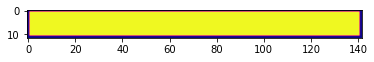

1.499991355417806 -8.644582194072825e-06


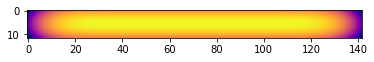

1.4998075770640722 -7.036771949575638e-07


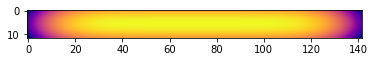

1.499632117605578 -7.00507718942589e-07


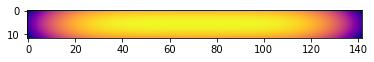

1.49945720215869 -6.989519645284048e-07


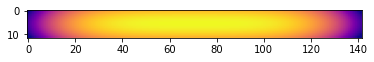

1.4992826010875218 -6.979158806430519e-07


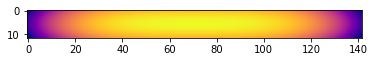

1.4991082251812031 -6.971237913599992e-07


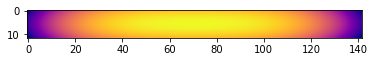

1.4989340285899868 -6.964692336186573e-07


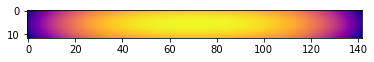

1.4987599840190247 -6.959012548435339e-07


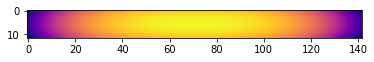

1.498586073629168 -6.953920816954451e-07


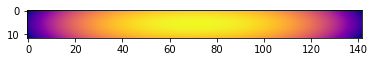

1.4984122849591257 -6.949251896148922e-07


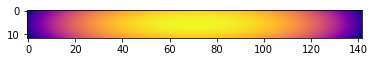

1.4982386088449695 -6.944901032035489e-07


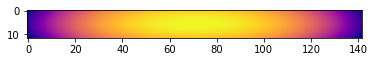

1.498065038261199 -6.940798922272506e-07


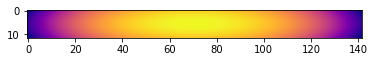

1.4978915676351687 -6.936896919107483e-07


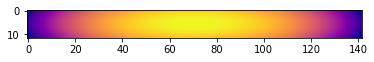

1.4977181924233944 -6.933160099364954e-07


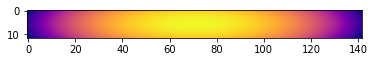

1.4975449088404125 -6.929562188506821e-07


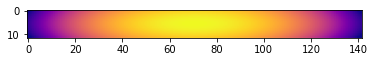

1.4973717136795108 -6.926082833924596e-07


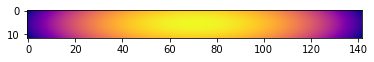

1.4971986041903134 -6.922705630962867e-07


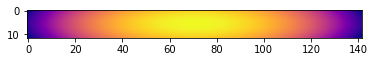

1.4970255779921564 -6.919417183670618e-07


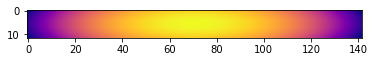

1.496852633010727 -6.916206243268164e-07


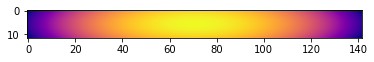

1.496679767429924 -6.913063383962026e-07


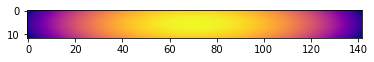

1.4965069796542445 -6.909980365676915e-07


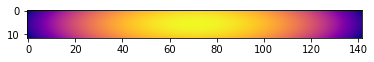

1.4963342682784329 -6.906950102969489e-07


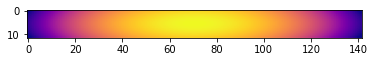

1.4961616320624789 -6.903966403015716e-07


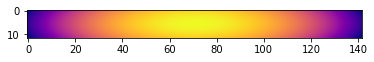

1.4959890699106413 -6.901024003358458e-07


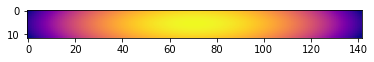

1.495816580853546 -6.898117914655444e-07


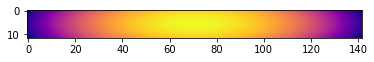

1.4956441640328069 -6.89524421559895e-07


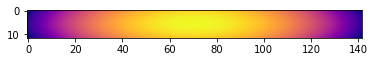

1.4954718186876652 -6.892399264657456e-07


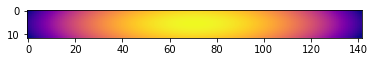

1.4952995441433876 -6.889579520219513e-07


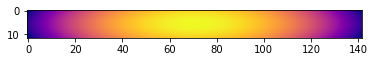

1.495127339801029 -6.88678248206287e-07


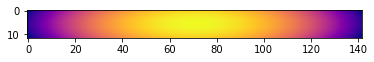

1.4949552051285289 -6.884005476770483e-07


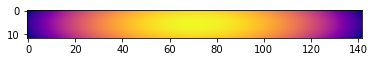

1.4947831396528297 -6.881246372714145e-07


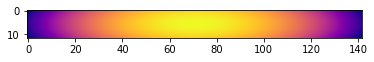

1.4946111429529603 -6.878503173712858e-07


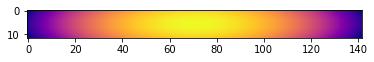

1.49443921465394 -6.875773927994544e-07


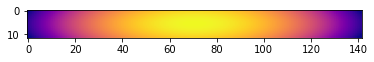

1.494267354421365 -6.873057420975215e-07


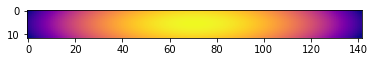

1.4940955619566918 -6.870352273757874e-07


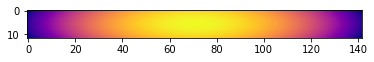

1.493923836993049 -6.8676571207682e-07


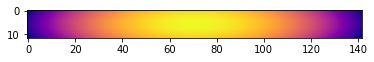

1.4937521792914956 -6.86497111601625e-07


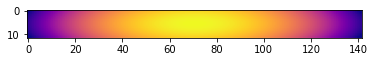

1.4935805886378104 -6.862293233655947e-07


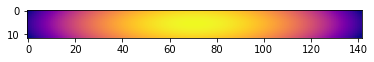

1.4934090648395761 -6.859622505572815e-07


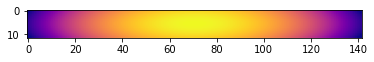

1.493237607723627 -6.856958412182479e-07


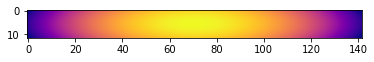

1.4930662171338094 -6.854300242942202e-07


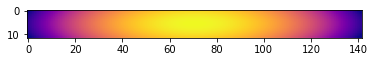

1.492894892929 -6.851647529337868e-07


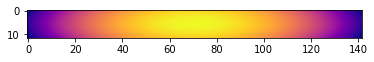

1.492723634981353 -6.848999654085475e-07


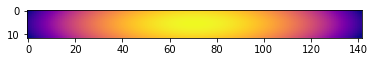

1.4925524431747397 -6.846356201961612e-07


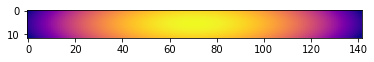

1.4923813174033964 -6.843716777726883e-07


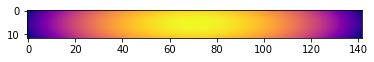

1.4922102575706806 -6.8410810927233e-07


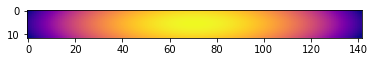

1.4920392635880655 -6.838448640689165e-07


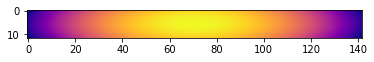

1.49186833537413 -6.835819450490277e-07


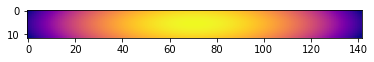

1.4916974728537629 -6.83319320460285e-07


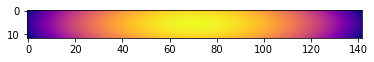

1.4915266759574537 -6.830569547755516e-07


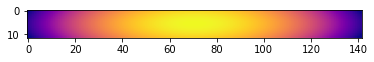

1.4913559446205717 -6.82794840445311e-07


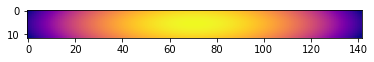

1.4911852787828652 -6.825329499360322e-07


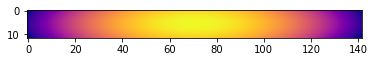

1.4910146783878881 -6.82271293461767e-07


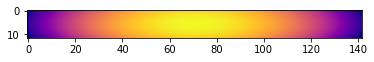

1.490844143382634 -6.820098352733339e-07


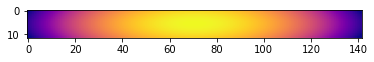

1.4906736737170607 -6.81748569819618e-07


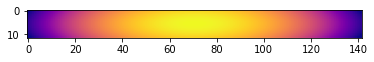

1.4905032693437843 -6.814874915495039e-07


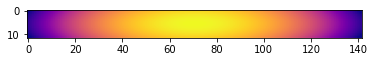

1.4903329302177728 -6.812265871403156e-07


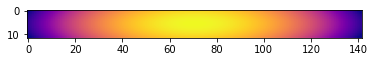

1.4901626562960504 -6.809658568140975e-07


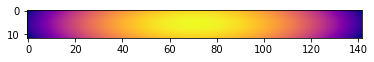

1.4899924475374755 -6.807052863599949e-07


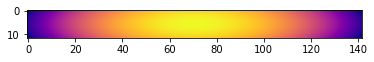

1.4898223039025305 -6.804448664521345e-07


In [53]:
avT_k_1 = ambient
diff_array = []
av_array = []


for i in range(15000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
    diff = avT_k-avT_k_1
    avT_k_1 = avT_k
    
    if i%250 == 0:
        plot(T_k_updated)        
        print(avT_k, diff)

    if i%100 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

# Test with a change of dimensions, the answer is still roughly the same

In [10]:
ambient = 1.14

top = np.array([ambient for i in range(280)])
bottom = top.copy()
left = np.array([ambient for i in range(20)])
right = left.copy()

q = 0.5*1e9 # W/m^3
T_a = 293*28 # K
K_si = 150 # W/mK
h = 0.5e-4 # m

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])

In [12]:
# Frist run
T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, h)

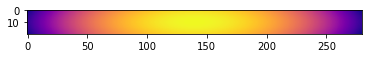

1.0306892252506406 -0.10931077474935935


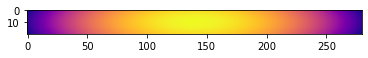

1.0306971617580232 7.936507382622082e-06


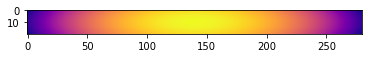

1.0307051139487091 7.952190685944771e-06


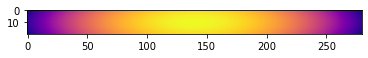

1.0307130640977147 7.950149005564455e-06


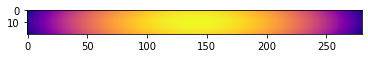

1.0307210119467343 7.947849019585007e-06


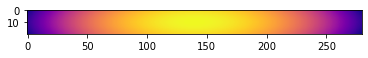

1.0307289573956668 7.94544893256699e-06


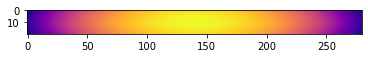

1.030736900393308 7.942997641174898e-06


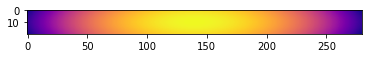

1.0307448409093647 7.940516056681446e-06


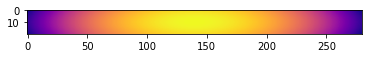

1.0307527789242914 7.938014926711645e-06


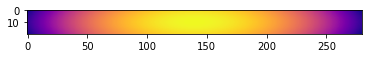

1.030760714424624 7.935500332623135e-06


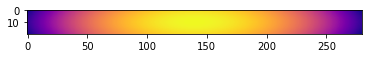

1.0307686474006368 7.932976012758886e-06


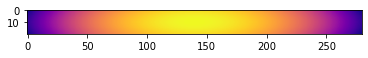

1.030776577845057 7.93044442026769e-06


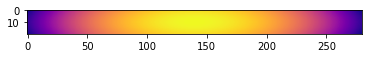

1.0307845057522693 7.927907212268437e-06


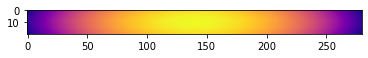

1.030792431117828 7.925365558714148e-06


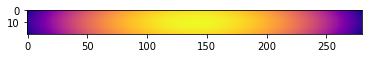

1.0308003539381863 7.92282035821934e-06


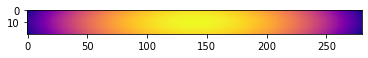

1.0308082742104454 7.92027225915426e-06


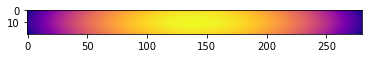

1.0308161919322376 7.917721792205512e-06


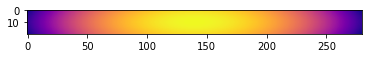

1.0308241071016435 7.9151694059032e-06


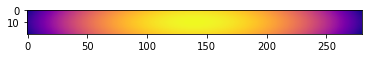

1.0308320197171073 7.91261546373434e-06


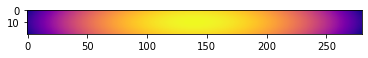

1.0308399297773387 7.910060231486327e-06


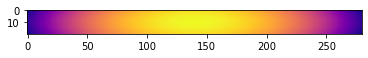

1.0308478372813328 7.907503994042386e-06


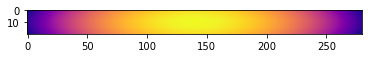

1.030855742228319 7.904946986325712e-06


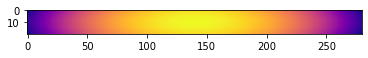

1.0308636446177069 7.902389387748343e-06


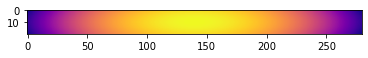

1.0308715444490668 7.899831359958753e-06


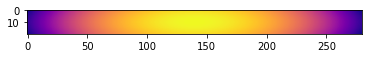

1.030879441722119 7.897273052170917e-06


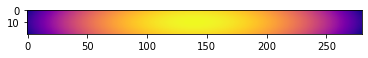

1.030887336436737 7.8947146180397e-06


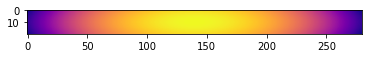

1.0308952285928978 7.892156160815844e-06


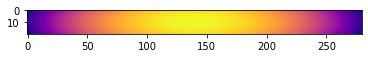

1.030903118190651 7.889597753107935e-06


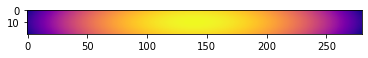

1.030911005230186 7.887039535026119e-06


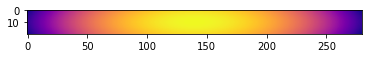

1.030918889711715 7.8844815289969e-06


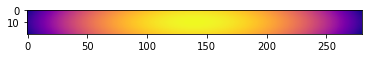

1.0309267716355734 7.88192385847708e-06


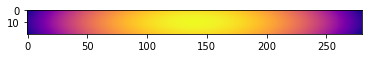

1.0309346510021196 7.879366546115207e-06


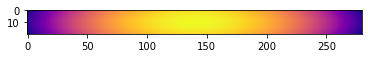

1.030942527811768 7.876809648532657e-06


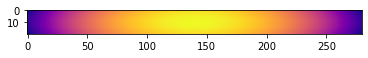

1.030950402065004 7.874253235895523e-06


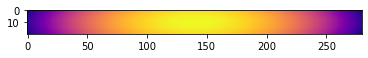

1.0309582737623173 7.871697313310833e-06


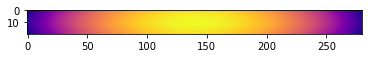

1.0309661429042778 7.869141960492598e-06


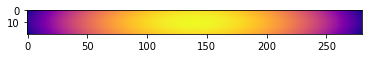

1.0309740094914661 7.866587188321006e-06


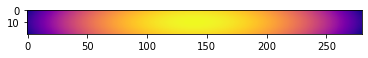

1.0309818735244716 7.864033005455795e-06


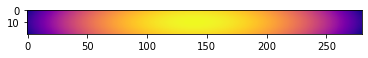

1.0309897350039403 7.861479468740384e-06


KeyboardInterrupt: 

In [19]:
avT_k_1 = ambient
diff_array = []
av_array = []

T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated+0.01, q, h)

for i in range(100000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, h)
    
    if i%1000 == 0:
        plot(trim(T_k_updated))        
        avT_k = sum(trim(T_k_updated).ravel().A1)/(len(trim(T_k_updated))*len(trim(T_k_updated)[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k

    if i%1000 == 0 and i >= 2000:

        diff_array.append(diff)
        av_array.append(avT_k)

In [11]:
def trim(M):
    rows = len(M)
    cols = len(M[0].A1)
    
    M_list = M.A1[cols:-cols]
    M = np.matrix(M_list.reshape(rows-2, cols)).transpose()
    M_list = M.A1[rows-2:-(rows-2)]
    M = np.matrix(M_list.reshape(cols-2, rows-2)).transpose()
    
    return M
    

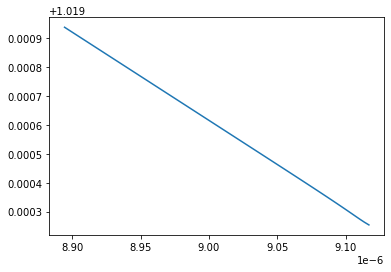

In [118]:
plt.plot(diff_array, av_array)

In [126]:
def func(x,a,b):
    return a*x + b

from scipy.optimize import curve_fit

fit, cov = curve_fit(func, diff_array, av_array)

-5.024525308705563e-06
1.0469446892947807


1.046939664769472

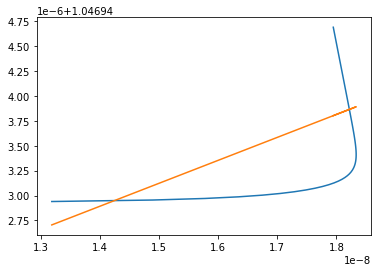

In [127]:
plt.plot(diff_array, av_array)
plt.plot(diff_array, [func(i, fit[0], fit[1]) for i in diff_array])
print(fit[1]-avT_k)
print(avT_k)
fit[1]

## Saving the data from a long run

In [130]:
import pandas as pd

data = np.matrix([av_array, diff_array])
df = pd.DataFrame(data.transpose())

In [134]:
df.columns = ['AverageTemp', 'DiffFromLast1kIterations']
df.to_csv("Average_Temp_240_by_20_around_equelibrium.csv", index=False)